In [28]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_absolute_error
from scipy.optimize import minimize
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.linear_model import LinearRegression


In [40]:

# ID du Google Sheet et GID de l'onglet
sheet_id = "1PdnadzZswADLqGBrI53a_8IsegivCMSz1pCZOh384-Y"
gid = "1517184233"

# Construction du lien CSV public de Google Sheets
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv&gid={gid}"

# Lecture du CSV directement dans un DataFrame
df = pd.read_csv(url)

# Si ton tableau commence à la colonne D (donc avec des colonnes vides avant),
# on peut supprimer les colonnes vides automatiquement :
df = df.dropna(axis=1, how="all")
df = df.replace("-", np.nan)
df = df.dropna(subset=["Team Gap Early", "R", "Perf relative", "Perf intrinsèque"])
df['LoseStreak'] = 0
streak = 0
for i, gap in enumerate(df['Team Gap Early']):
    if gap < 0:
        streak += 1
    else:
        streak = 0
    df.at[i, 'LoseStreak'] = streak

**ATTENTION** : cette formule fait une prédiction entre 20 ET 80 pour le **TEAM GAP EARLY**, pas une prédiction sur la WIN. (on peut le changer)
- Actuellement cette formule est pour la ligne 9 puis il faut la faire glisser sur les autres cases après


In [41]:
features = ["Team Gap Early", "R", "Perf relative", "Perf intrinsèque", "LoseStreak"]

# Séparer R et LoseStreak du reste
features_to_scale = ["Team Gap Early", "Perf relative", "Perf intrinsèque"]

scaler = StandardScaler()
data_scaled = scaler.fit_transform(df[features_to_scale])

# Concaténer R et LoseStreak en valeur brute
R_raw = df["R"].values.reshape(-1, 1)
streak_raw = df["LoseStreak"].values.reshape(-1, 1)

data_final = np.hstack([
    data_scaled[:, 0:1],  # Team Gap Early
    R_raw,                # R brut
    data_scaled[:, 1:3],  # Perf relative, Perf intrinsèque
    streak_raw             # LoseStreak brut
])

window = 7
X, y = [], []

for i in range(len(data_final) - window):
    X.append(data_final[i:i+window])
    y.append(data_final[i + window, 0])  # prédire Team Gap Early

X = np.array(X)
y = np.array(y)

# --- Dataset PyTorch ---
class LoLDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = LoLDataset(X, y)
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)

# --- LSTM ---
class LoLModel(nn.Module):
    def __init__(self, input_size=5, hidden_size=32, num_layers=1):  # input_size = 5 maintenant
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # dernière sortie
        return out.squeeze(1)

model = LoLModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# --- Entraînement ---
for epoch in range(200):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss / len(train_loader):.4f}")

# --- Approximation linéaire sur la sortie avant sigmoid ---
model.eval()
with torch.no_grad():
    lstm_out, _ = model.lstm(torch.tensor(X, dtype=torch.float32))
    fc_out = model.fc(lstm_out[:, -1, :]).numpy().flatten()  # avant sigmoid

X_flat = X.reshape(X.shape[0], -1)
lin_model = LinearRegression()
lin_model.fit(X_flat, fc_out)

Epoch 0, Loss: 0.9974
Epoch 50, Loss: 0.3007
Epoch 100, Loss: 0.0326
Epoch 150, Loss: 0.0015


LinearRegression()

In [47]:
def generate_excel_formula_lstm_sigmoid_amplify_R(row, coefs, intercept, window=7, alpha_R=5.0):
    features_letters = ["F", "G", "H", "I"]  # TeamGapEarly, R, PerfRel, PerfIntr
    inner = f"{intercept:.6f}".replace(".", ",")
    
    for feat_idx, col_letter in enumerate(features_letters):
        inner += "+("
        for lag_idx in range(window):
            coef_idx = feat_idx * window + lag_idx
            coef = coefs[coef_idx]
            if col_letter == "G":  # Amplifier R
                coef *= alpha_R
            lag_row = row - (window - lag_idx)
            inner += f"{coef:.6f}*{col_letter}{lag_row}+"
        inner = inner.rstrip("+") + ")"
    
    # Sigmoid + rescaling
    formula = f"=20 + 60 * (1 / (1 + EXP(-({inner}))))"
    formula = formula.replace(".", ",")
    return formula

row_number = 31
excel_formula_row31 = generate_excel_formula_lstm_sigmoid_amplify_R(
    row=row_number,
    coefs=lin_model.coef_,
    intercept=lin_model.intercept_,
    window=7,
    alpha_R=1.0  # facteur d'amplification
)

print(excel_formula_row31)


=20 + 60 * (1 / (1 + EXP(-(0,518818+(0,426903*F24+-0,413407*F25+-0,271521*F26+-0,762807*F27+0,540077*F28+-0,018481*F29+-0,242964*F30)+(-0,187610*G24+0,050341*G25+0,068316*G26+-0,532262*G27+0,281040*G28+0,099863*G29+0,117314*G30)+(0,091600*H24+-0,241438*H25+-0,486221*H26+-0,793569*H27+-0,059740*H28+0,113519*H29+-0,494593*H30)+(-0,102135*I24+-0,091243*I25+-0,408887*I26+-0,322141*I27+0,261962*I28+-0,029584*I29+0,382865*I30)))))


### Bonus matrice de corrélation

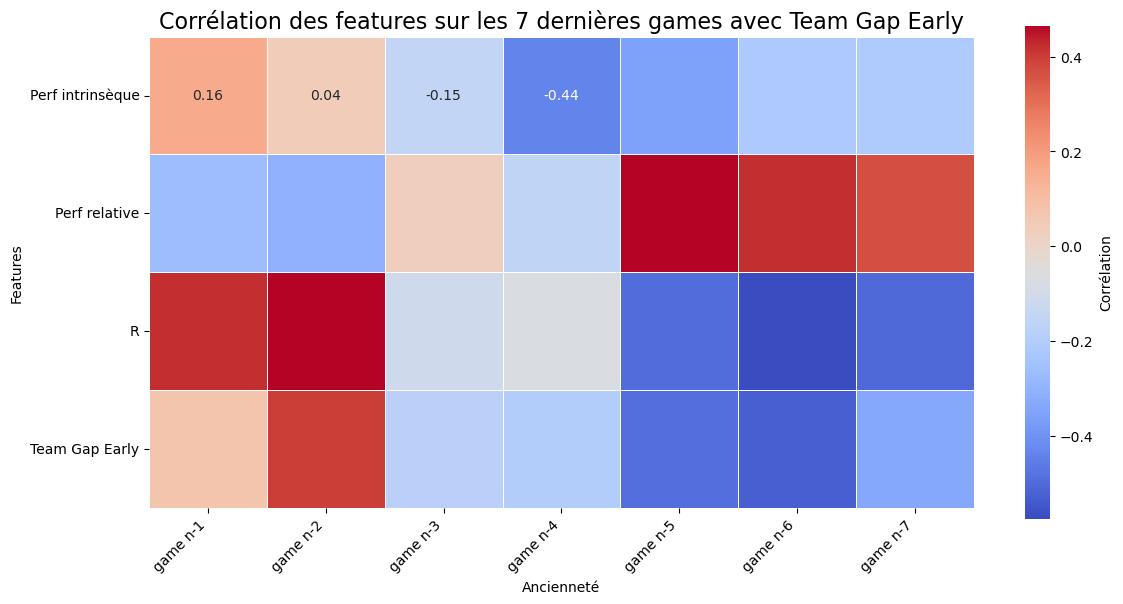

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

features = ['R', 'Perf relative', 'Perf intrinsèque', 'Team Gap Early']
target = 'Team Gap Early'
max_lag = 7

df_lagged = df.copy()

# Créer les colonnes lag
for feat in features:
    for lag in range(1, max_lag + 1):
        df_lagged[f'{feat}_lag{lag}'] = df_lagged[feat].shift(lag)

# Supprimer les lignes avec target NaN
df_corr = df_lagged.dropna(subset=[target])

# Calcul des corrélations
corr_dict = {}
for feat in features:
    for lag in range(1, max_lag + 1):
        corr_dict[f'{feat}_lag{lag}'] = df_corr[target].corr(df_corr[f'{feat}_lag{lag}'])

corr_df = pd.DataFrame.from_dict(corr_dict, orient='index', columns=['Correlation'])
corr_df['Feature'] = [name.split('_lag')[0] for name in corr_df.index]
corr_df['Lag'] = [int(name.split('_lag')[1]) for name in corr_df.index]

# Pivot pour heatmap
heatmap_data = corr_df.pivot(index='Feature', columns='Lag', values='Correlation')

# Heatmap avec labels
plt.figure(figsize=(12, 6))
ax = sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar_kws={'label': 'Corrélation'},
    linewidths=0.5,
    square=True
)

# Forcer les labels pour toutes les cases
ax.set_xticklabels([f"game n-{i}" for i in heatmap_data.columns], rotation=45, ha='right', fontsize=10)
ax.set_yticklabels(heatmap_data.index, rotation=0, fontsize=10)

plt.title('Corrélation des features sur les 7 dernières games avec Team Gap Early', fontsize=16)
plt.xlabel('Ancienneté')
plt.ylabel('Features')
plt.tight_layout()
plt.show()
